# Important! Instaling dynamicTreeCut
use this:
pip install git+https://github.com/kylessmith/dynamicTreeCut

If you get the below error

- KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([0, 1], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

You need to modify 'dynamicTreeCut.py' from your site-packages directory. Go to line ~762 and do this:

- comment this line:
-- \# SizeRank = rankdata(-Sizes[np.arange(len(Sizes))], method="ordinal")
- replace it with: 
-- SizeRank = rankdata(-Sizes.iloc[np.arange(len(Sizes))], method="ordinal")  # Babak fix
- restart your Jupyter kernel!

# Clustering FNDDS Datasets #

In [1]:
# import xport
import numpy as np
import pandas as pd
import os

# import networkx as nx

#https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
# pd.set_option('display.float_format', lambda x: '%.4f' % x)

from IPython.display import display
from PIL import Image

# from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score, homogeneity_score, v_measure_score, completeness_score

"""
Connect Plotly to Jupyter notebook
"""

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
init_notebook_mode(connected=True)

from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.io as pio

matplotlib.rcParams['font.serif'] = "serif"
matplotlib.rcParams['font.family'] = "Times New Roman"
# 

from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
import sklearn as skl
import scipy.cluster.hierarchy as sch

from sklearn.decomposition import PCA

# silence NumbaPerformanceWarning
import warnings
from numba.core.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

"""
Autoreload base modules
"""

%load_ext autoreload
%autoreload 1
%aimport cluster_analysis

# Clustering based on Nutrient Panels

In [2]:
data_orig = pd.read_csv('FNDDS0910_99Nutrients_5folds_SMOTE_RFFNDDScleanedwithsalt_additionallab_PREDICTION99_5folds_SMOTE.csv',
                        index_col=0)

# Remove table salt from hierarchichal clustring
data_orig = data_orig[data_orig['Food_code'] != 2047].reset_index(drop=True)

# data_orig = pd.read_csv('RFFNDDS_2009_10_recom_Giulia_Raws_salt_99_nuts.csv',
#                         index_col=0)

In [3]:
# FNDDS hierarchy
data_orig['Level1']=[str(n)[0] for n in data_orig['Food_code']]
data_orig['Level2']=[str(n)[0:2] for n in data_orig['Food_code']]
data_orig['Level3']=[str(n)[0:3] for n in data_orig['Food_code']]

In [4]:
if 'Total Vitamin A' not in data_orig.columns:
    print('''THIS ASSUMED THE DATA IS ALREADY LOG-TRANSFORMED!!!''')
    no_trans_df = data_orig.loc[:, "Protein": "Total isoflavones"].replace(-20, np.NaN).apply(np.exp).fillna(0)
    
    data_orig['Total Vitamin A'] = (
        (
            no_trans_df['Retinol'] + no_trans_df['Carotene, beta'] + no_trans_df['Carotene, alpha'] + no_trans_df['Cryptoxanthin, beta']
        )
        .apply(np.log)
        .replace([np.inf, -np.inf], -20)
    )
    
    print('Added "Total Vitamin A"')

THIS ASSUMED THE DATA IS ALREADY LOG-TRANSFORMED!!!
Added "Total Vitamin A"


In [5]:
# FNDDS_categories = pd.read_csv('2009 FNDDS Category by Frequency Tree.csv')
FNDDS_categories = pd.read_excel('2015-2016 FNDDS Category Frequencies - BR.xlsx')
FNDDS_categories['Category Code'] = FNDDS_categories['Category Code'].astype(str)

cutoff_lenght = 50
FNDDS_categories['Category Name full'] = FNDDS_categories['Category Name']
FNDDS_categories['Category Name'] = FNDDS_categories['Category Name full'].apply(
    lambda l: l[0:cutoff_lenght] + "..." if len(l) > cutoff_lenght else l,
)

FNDDS_cats_code_label_dict = FNDDS_categories.set_index('Category Code')['Category Name'].to_dict()
FNDDS_cats_code_label_dict['35']

'Frozen plate meals with egg as major ingredient'

name: log_-20__metric_euclidean__method_ward__panel_99
..cutHeight not given, setting it to 2033.4420827302201  ===>  99% of the (truncated) height range in dendro.
..done.
Number of clusters: 20 [deepSplit: {'deepSplit': 1} | pred_class: class]


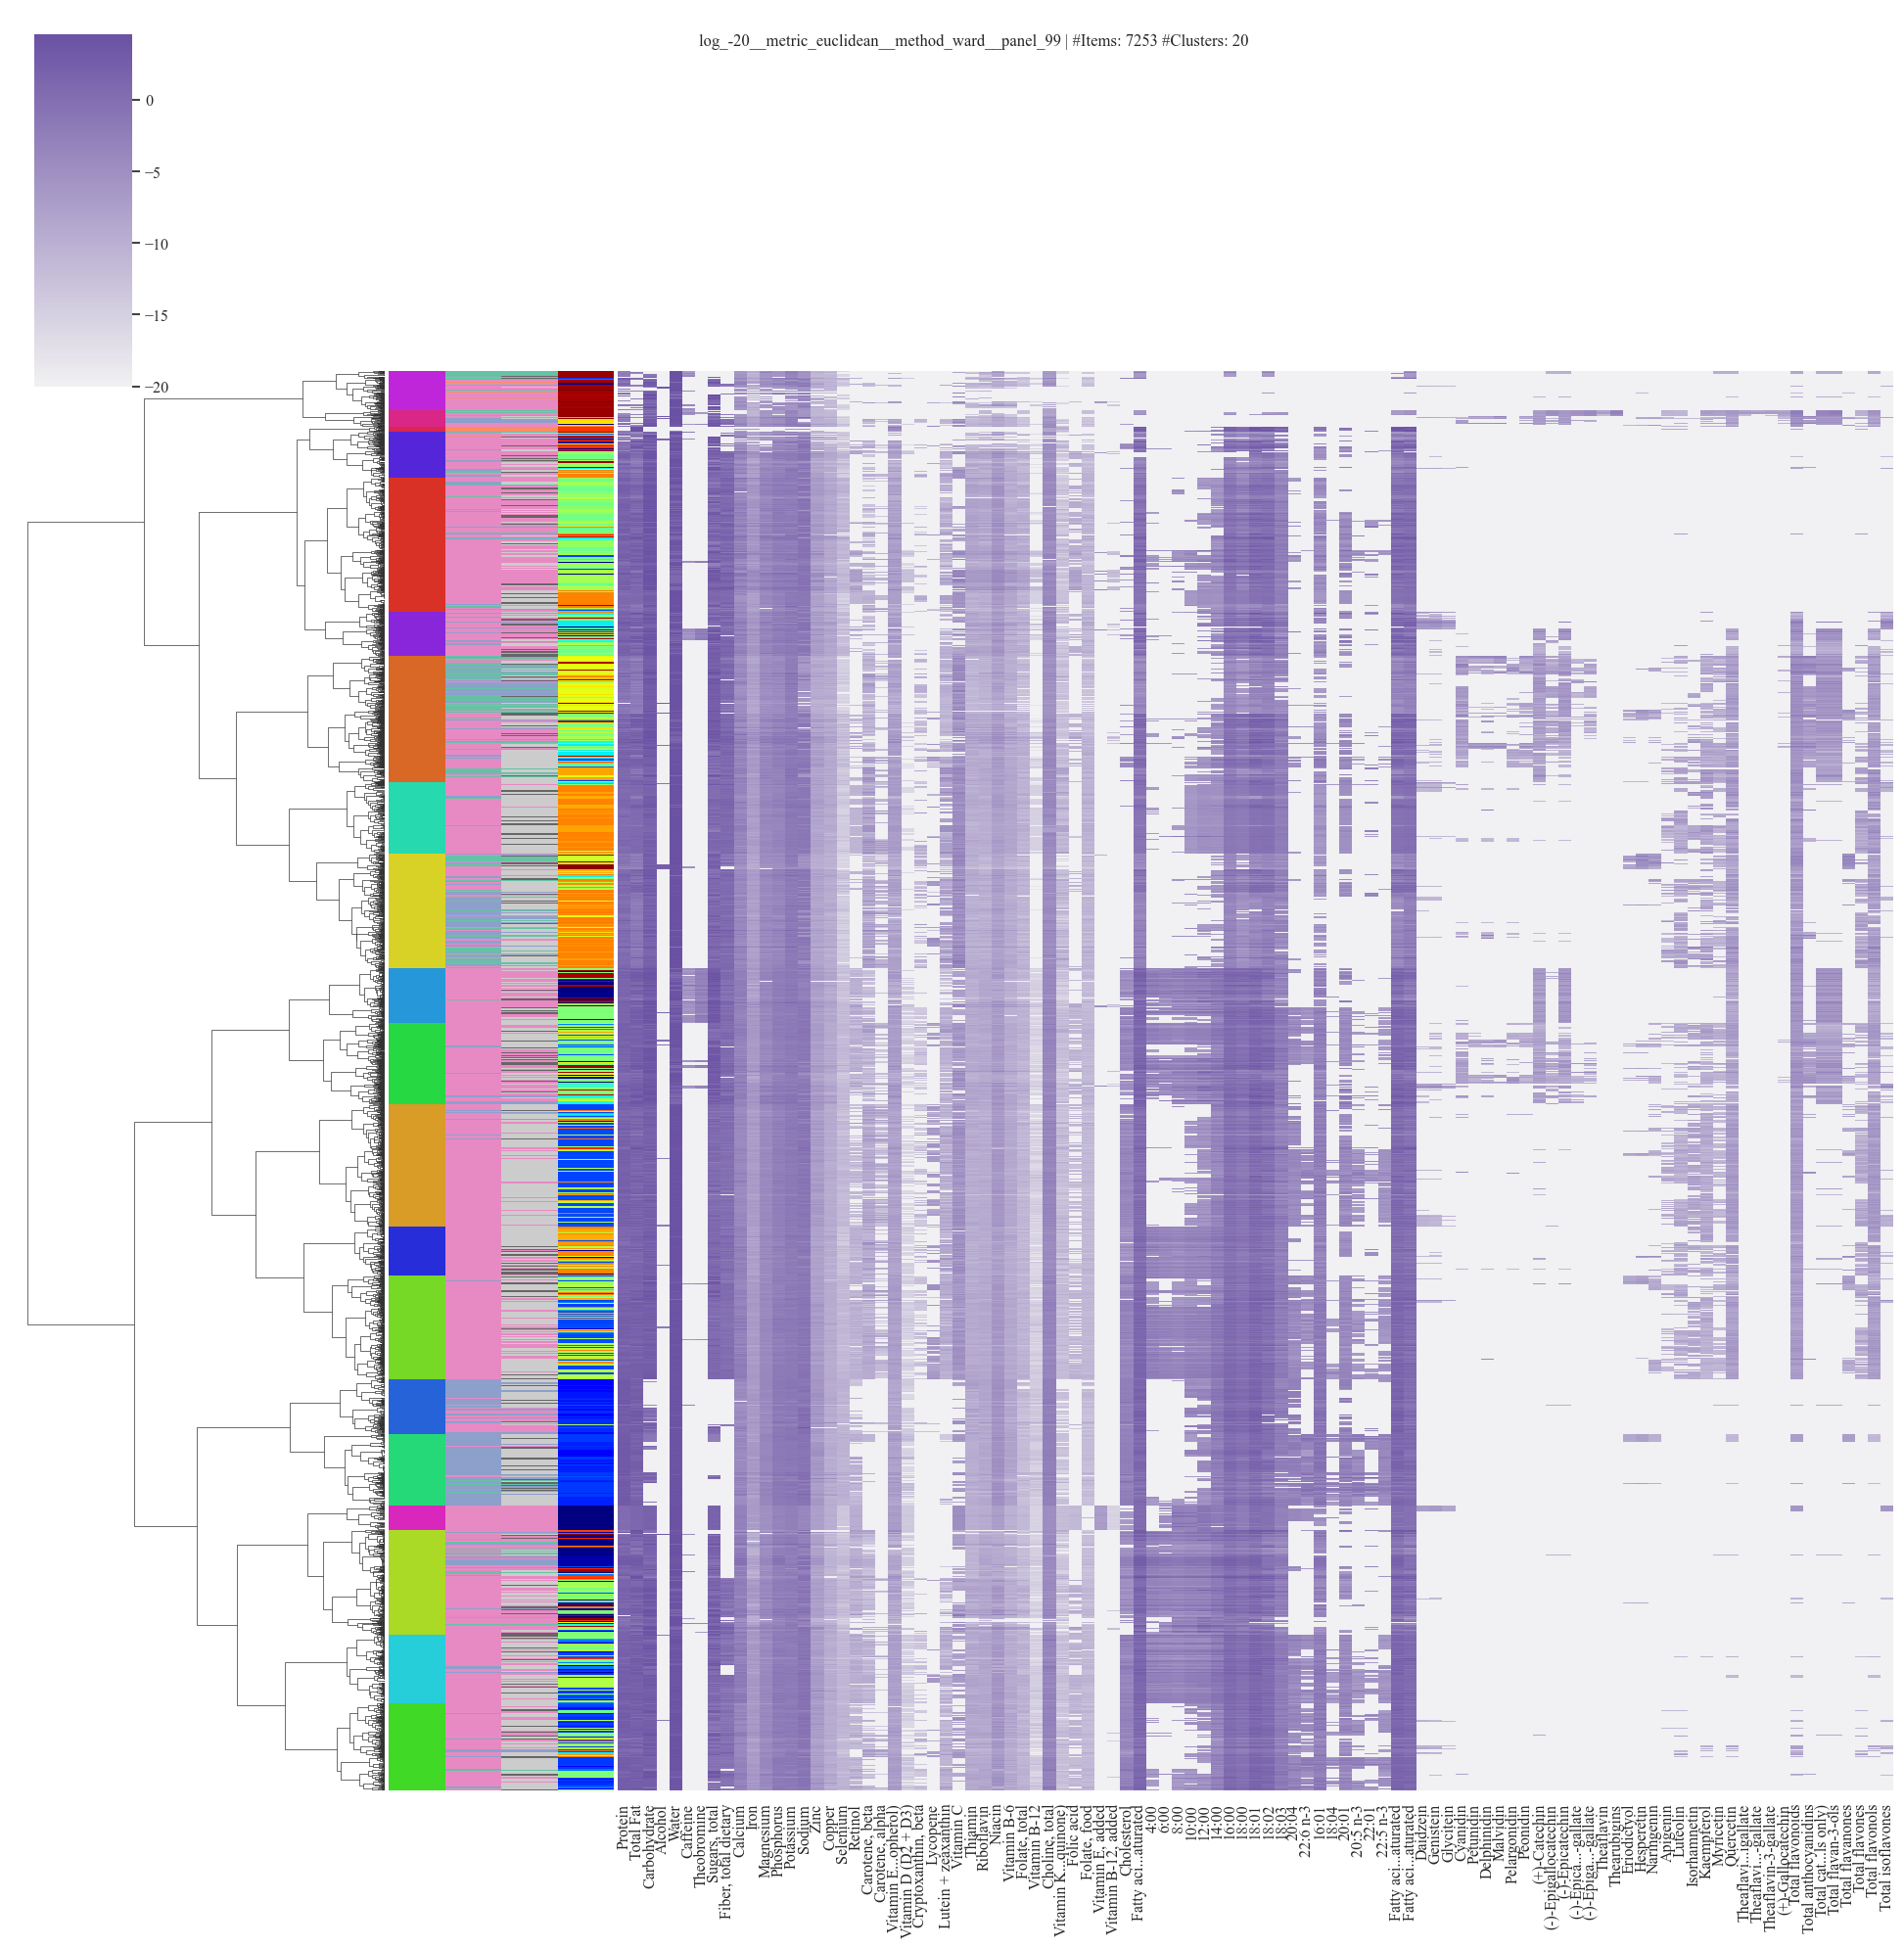

In [6]:
pdist_args={"metric": "euclidean"}
linkage_args= {"method": "ward"}
dynamic_cut_args={'deepSplit': 1}

'''select your ny panel'''
nut_panel = ["12", "62", "99"][2]
columns = cluster_analysis.get_nut_panel_columns(nut_panel)


font_scale = 1.05
save_excel = False
name = 'log_-20'


name = name + "__" + "__".join(
    ["{}_{}".format(k, v) for k, v in pdist_args.items()] + ["{}_{}".format(k, v) for k, v in
                                                             linkage_args.items()]) + "__panel_" + nut_panel

print('name:', name)


FNDDS_probs = {
    # 'probs': 'data/FNDDS/predictions/RFFNDDS_2009_10_recom_Giulia_Raws_12_nuts.csv',
    'probs': None,
    'name': name,
    'dynamic_cut_args': dynamic_cut_args,
    'lut': None,
    'NOVA_pred_column': 'class',
    'NOVA_truth_column': 'novaclass',
    'description_column': 'Main_food_description',
    'food_code_col': 'Food_code',
    'map_cluster_to_NOVA_beyond': None,
    'map_cluster_to_NOVA_UP_merged': None,
    'FNDDS16_p_vals_clusters_NOVA_map': None
}


FNDDS_probs["lut"] = None

results_dict = cluster_analysis.do_clusters(
    dynamic_cut_args=FNDDS_probs["dynamic_cut_args"],
    data=data_orig,
    features=columns,
    description_column=FNDDS_probs["description_column"],
    show_color_luts_for_pred_and_NOVA_truth=True,
    save_path="data/FNDDS/TreeCut/",
    save_file_name=None,
    save_excel=save_excel,
    open_excel=False,
    font_scale=font_scale,
    figsize=(20, 20),
    fig_dpi=100,  
    # figsize=(30, 27),
    NOVA_class_column=FNDDS_probs["NOVA_pred_column"],
    fontfamily='Times New Roman',
    name=FNDDS_probs["name"],
    cmap=sns.light_palette("#6a51a3", as_cmap=True),
    lut_cat_dynamic_tree=FNDDS_probs["lut"],
    xticklabels=[str(l[0:9]) + "..." + str(l[-8:]) if len(l) > 20 else l for l in columns],
    linkage_args=linkage_args, 
    pdist_args=pdist_args,
    color_level2_FNDDS_category=True,
    FNDDS_cats_code_label_dict=FNDDS_cats_code_label_dict
)

display(Image.open(results_dict['paths_figures']['cluster_map']))

In [7]:
# data_orig.to_csv('D:/FProXFinal/FigS04/')
print(list(data_orig.columns))

data_orig_export = data_orig[['class', 'DynamicTreeCut', 'Level2', 'novaclass'] + columns].reset_index(drop=True)
data_orig_export['class'] += 1

data_orig_export = data_orig_export[['class', 'DynamicTreeCut', 'Level2', 'novaclass'] + columns].rename(columns={
    'DynamicTreeCut': 'Hierarchical Clustering Classification', 'class': 'Random Forest NOVA Classification',
    'novaclass': 'NOVA Manual Classification Classification', 'Level2': 'FNDDS Level2 Food Code Categories'
})

data_orig_export.to_csv('D:/FProXFinal/FigS04/FigS4.csv')

data_orig_export

['Protein', 'Total Fat', 'Carbohydrate', 'Alcohol', 'Water', 'Caffeine', 'Theobromine', 'Sugars, total', 'Fiber, total dietary', 'Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Copper', 'Selenium', 'Retinol', 'Carotene, beta', 'Carotene, alpha', 'Vitamin E (alpha-tocopherol)', 'Vitamin D (D2 + D3)', 'Cryptoxanthin, beta', 'Lycopene', 'Lutein + zeaxanthin', 'Vitamin C', 'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B-6', 'Folate, total', 'Vitamin B-12', 'Choline, total', 'Vitamin K (phylloquinone)', 'Folic acid', 'Folate, food', 'Vitamin E, added', 'Vitamin B-12, added', 'Cholesterol', 'Fatty acids, total saturated', '4:00', '6:00', '8:00', '10:00', '12:00', '14:00', '16:00', '18:00', '18:01', '18:02', '18:03', '20:04', '22:6 n-3', '16:01', '18:04', '20:01', '20:5 n-3', '22:01', '22:5 n-3', 'Fatty acids, total monounsaturated', 'Fatty acids, total polyunsaturated', 'Daidzein', 'Genistein', 'Glycitein', 'Cyanidin', 'Petunidin', 'Delphinidin', 'Malvidin', 'Pela

,Random Forest NOVA Classification,Hierarchical Clustering Classification,FNDDS Level2 Food Code Categories,NOVA Manual Classification Classification,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Selenium,Retinol,"Carotene, beta","Carotene, alpha",Vitamin E (alpha-tocopherol),Vitamin D (D2 + D3),"Cryptoxanthin, beta",Lycopene,Lutein + zeaxanthin,Vitamin C,Thiamin,Riboflavin,Niacin,Vitamin B-6,"Folate, total",Vitamin B-12,"Choline, total",Vitamin K (phylloquinone),Folic acid,"Folate, food","Vitamin E, added","Vitamin B-12, added",Cholesterol,"Fatty acids, total saturated",4:00,6:00,8:00,10:00,12:00,14:00,16:00,18:00,18:01,18:02,18:03,20:04,22:6 n-3,16:01,18:04,20:01,20:5 n-3,22:01,22:5 n-3,"Fatty acids, total monounsaturated","Fatty acids, total polyunsaturated",Daidzein,Genistein,Glycitein,Cyanidin,Petunidin,Delphinidin,Malvidin,Pelargonidin,Peonidin,(+)-Catechin,(-)-Epigallocatechin,(-)-Epicatechin,(-)-Epicatechin 3-gallate,(-)-Epigallocatechin 3-gallate,Theaflavin,Thearubigins,Eriodictyol,Hesperetin,Naringenin,Apigenin,Luteolin,Isorhamnetin,Kaempferol,Myricetin,Quercetin,"Theaflavin-3,3'-digallate",Theaflavin-3'-gallate,Theaflavin-3-gallate,(+)-Gallocatechin,Total flavonoids,Total anthocyanidins,Total catechins (monomeric flavan-3-ols only),Total flavan-3-ols,Total flavanones,Total flavones,Total flavonols,Total isoflavones
0,1,13,11,1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,-10.414313,-5.809143,-4.268698,-2.975930,-4.074542,-8.679712,-9.864267,-13.227724,-9.721166,-11.869600,-20.0,-9.433484,-16.118096,-20.0,-20.0,-20.0,-5.298317,-11.176453,-10.231992,-8.639361,-11.417615,-12.206073,-16.811243,-4.135167,-15.019483,-20.000000,-12.206073,-20.000000,-20.000000,-4.268698,0.697637,-20.000000,-20.000000,-20.000000,-2.764621,-1.362578,-1.136314,-0.084469,-1.227583,0.388658,-0.983499,-2.956512,-3.649659,-20.0,-2.047943,-20.0,-3.218876,-20.0,-20.0,-20.0,0.505612,-0.699165,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0
1,1,5,11,1,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,-10.414313,-4.509860,-2.396896,-1.951928,-3.123566,-7.751725,-11.176453,-12.684108,-9.845219,-12.429216,-20.0,-10.126631,-13.633189,-20.0,-20.0,-20.0,-9.210340,-10.126631,-8.622554,-9.293722,-10.204593,-12.206073,-14.528860,-4.147745,-15.424948,-20.000000,-12.206073,-20.000000,-20.000000,-4.961845,0.143234,-2.864704,-3.194183,-3.411248,-3.079114,-3.015935,-1.754464,-0.667479,-1.491655,-0.727739,-2.733368,-3.611918,-20.000000,-20.0,-4.342806,-20.0,-6.907755,-20.0,-20.0,-20.0,-0.679244,-2.364460,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0
2,1,5,11,1,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,-10.414313,-4.605170,-2.476938,-2.024953,-3.146555,-7.902008,-10.596635,-12.507178,-10.008848,-11.869600,-20.0,-9.567015,-13.553146,-20.0,-20.0,-20.0,-20.000000,-9.986869,-8.685612,-9.326874,-10.231992,-12.206073,-14.614018,-4.247496,-15.019483,-20.000000,-12.206073,-20.000000,-20.000000,-4.605170,0.623261,-2.590267,-2.590267,-2.590267,-2.590267,-2.563950,-1.214023,-0.187535,-1.007858,-0.208255,-2.120264,-2.590267,-20.000000,-20.0,-20.000000,-20.0,-20.000000,-20.0,-20.0,-20.0,-0.208255,-1.634756,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0
3,1,5,11,1,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,-9.90

In [8]:
max(data_orig.loc[:, "Protein": "Total isoflavones"].max())

4.6051701860000005

In [9]:
cluster_analysis.NOVA_predictions_colors_dict

{'NOVA 1': '#66c2a5',
 'NOVA 2': '#fc8d62',
 'NOVA 3': '#8da0cb',
 'NOVA 4': '#e78ac3'}

{'NOVA_truth': 'data/FNDDS/TreeCut//DTC_log__20__metric_euclidean__method_ward__panel_99_NOVA_truth_labels.png', 'NOVA_Predictions': 'data/FNDDS/TreeCut//DTC_log__20__metric_euclidean__method_ward__panel_99_NOVA_labels.png', 'FNDDS_level2_categories': 'data/FNDDS/TreeCut//DTC_log__20__metric_euclidean__method_ward__panel_99_FNDDS_Level2_Cats.png', 'clusters_labels': 'data/FNDDS/TreeCut//DTC_log__20__metric_euclidean__method_ward__panel_99_clusters_labels.png', 'cluster_map': 'data/FNDDS/TreeCut//DTC_log__20__metric_euclidean__method_ward__panel_99_clustermap.png'}


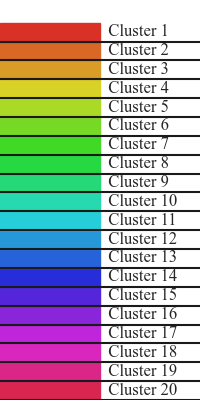

In [10]:
print(results_dict['paths_figures'])
display(Image.open(results_dict['paths_figures']['clusters_labels']))

data/FNDDS/TreeCut//DTC_log__20__metric_euclidean__method_ward__panel_99_FNDDS_Level2_Cats.png
FNDDS Level 2 Categories


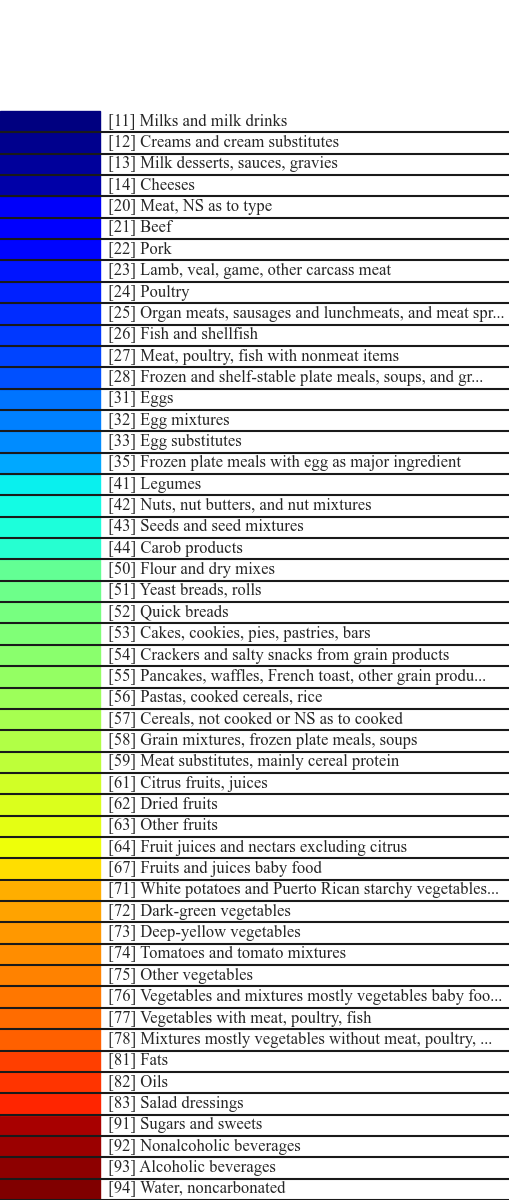

In [11]:
print(results_dict['paths_figures']['FNDDS_level2_categories'])
print('FNDDS Level 2 Categories')
display(Image.open(results_dict['paths_figures']['FNDDS_level2_categories']))

In [12]:
dynamic_cut_clusters_df = results_dict['data and clusters']

path_tmp = 'dynamic_cut_clusters_nutPanel_{}.csv'.format(nut_panel)
print('Saved clusters at:', path_tmp)
dynamic_cut_clusters_df.to_csv(path_tmp)

pd.DataFrame(
    dynamic_cut_clusters_df['DynamicTreeCut'].value_counts().reset_index().to_numpy(),
    columns=['cluster', 'count items']
)

Saved clusters at: dynamic_cut_clusters_nutPanel_99.csv


,cluster,count items
0,1,685
1,2,644
2,3,624
3,4,585
4,5,536
5,6,532
6,7,449
7,8,416
8,9,364
9,10,364


# Adjusted Mutual Information

In [13]:
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score

print('Clustering vs NOVA predicted')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['DynamicTreeCut'], dynamic_cut_clusters_df['class']))

print('Clustering vs NOVA label + missing')
print(adjusted_mutual_info_score(
    dynamic_cut_clusters_df['DynamicTreeCut'], 
    dynamic_cut_clusters_df['novaclass'])
)

print('Clustering vs NOVA training')

filterT=(dynamic_cut_clusters_df['novaclass']!=0)&(dynamic_cut_clusters_df['novaclass']!=12)

print(adjusted_mutual_info_score(dynamic_cut_clusters_df['DynamicTreeCut'][filterT], dynamic_cut_clusters_df['novaclass'][filterT]))
print('%%%%%%%%%%%%%%%%%%')
print('Clustering vs Level 1')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['DynamicTreeCut'], dynamic_cut_clusters_df['Level1']))

print('Clustering vs Level 2')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['DynamicTreeCut'], dynamic_cut_clusters_df['Level2']))

print('Clustering vs Level 3')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['DynamicTreeCut'], dynamic_cut_clusters_df['Level3']))

print('%%%%%%%%%%%%%%%%%%')
print('Level 1 vs Level 2')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level1'], dynamic_cut_clusters_df['Level2']))
print('Level 1 vs Level 3')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level1'], dynamic_cut_clusters_df['Level3']))
print('Level 2 vs Level 3')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level2'], dynamic_cut_clusters_df['Level3']))

print('%%%%%%%%%%%%%%%%%%')
print('Level 1 vs NOVA predicted')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level1'], dynamic_cut_clusters_df['class']))
print('Level 2 vs NOVA predicted')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level2'], dynamic_cut_clusters_df['class']))
print('Level 3 vs NOVA predicted')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level3'], dynamic_cut_clusters_df['class']))

print('%%%%%%%%%%%%%%%%%%')
print('Level 1 vs NOVA training')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level1'][filterT], dynamic_cut_clusters_df['novaclass'][filterT]))
print('Level 2 vs NOVA training')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level2'][filterT], dynamic_cut_clusters_df['novaclass'][filterT]))
print('Level 3 vs NOVA training')
print(adjusted_mutual_info_score(dynamic_cut_clusters_df['Level3'][filterT], dynamic_cut_clusters_df['novaclass'][filterT]))

Clustering vs NOVA predicted
0.14323148157673932
Clustering vs NOVA label + missing
0.11110292075563762
Clustering vs NOVA training
0.12435931834988341
%%%%%%%%%%%%%%%%%%
Clustering vs Level 1
0.3448173697947717
Clustering vs Level 2
0.39208580316427866
Clustering vs Level 3
0.38035960455056633
%%%%%%%%%%%%%%%%%%
Level 1 vs Level 2
0.7049190019178494
Level 1 vs Level 3
0.5517447479819919
Level 2 vs Level 3
0.8189248603626578
%%%%%%%%%%%%%%%%%%
Level 1 vs NOVA predicted
0.11992885846972769
Level 2 vs NOVA predicted
0.15369964394245855
Level 3 vs NOVA predicted
0.15409639675410436
%%%%%%%%%%%%%%%%%%
Level 1 vs NOVA training
0.18307255432977834
Level 2 vs NOVA training
0.2164957233591324
Level 3 vs NOVA training
0.22748830363186515
